In [1]:
!pip install -q transformers datasets lightning einops timm torchmetrics

In [2]:
from datasets import load_dataset

train_ds, test_ds = load_dataset("Maysee/tiny-imagenet", split=["train", "valid"])

Using custom data configuration Maysee--tiny-imagenet-2eb6c3acd8ebc62a
C:\Users\aonti\Anaconda3\envs\ResearchMethods\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset parquet (C:/Users/aonti/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 9832
})

In [9]:
import numpy as np

test_ds = test_ds.filter(lambda example: np.array(example["image"]).ndim == 3)

Loading cached processed dataset at C:\Users\aonti\.cache\huggingface\datasets\Maysee___parquet\Maysee--tiny-imagenet-2eb6c3acd8ebc62a\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-baeafd052d8975cf.arrow


In [10]:
len(test_ds)

9832

In [14]:
id2label = {idx: label for idx, label in enumerate(test_ds.features["label"].names)}
label2id = {label: idx for idx, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01882714', 12: 'n01910747', 13: 'n01917289', 14: 'n01944390', 15: 'n01950731', 16: 'n01983481', 17: 'n01984695', 18: 'n02002724', 19: 'n02056570', 20: 'n02058221', 21: 'n02074367', 22: 'n02094433', 23: 'n02099601', 24: 'n02099712', 25: 'n02106662', 26: 'n02113799', 27: 'n02123045', 28: 'n02123394', 29: 'n02124075', 30: 'n02125311', 31: 'n02129165', 32: 'n02132136', 33: 'n02165456', 34: 'n02226429', 35: 'n02231487', 36: 'n02233338', 37: 'n02236044', 38: 'n02268443', 39: 'n02279972', 40: 'n02281406', 41: 'n02321529', 42: 'n02364673', 43: 'n02395406', 44: 'n02403003', 45: 'n02410509', 46: 'n02415577', 47: 'n02423022', 48: 'n02437312', 49: 'n02480495', 50: 'n02481823', 51: 'n02486410', 52: 'n02504458', 53: 'n02509815', 54: 'n02666347', 55: 'n02669723', 56: 'n02699494', 57: 'n02769748', 58: 'n02788148', 59: 'n

In [15]:
from transformers import PerceiverFeatureExtractor

feature_extractor = PerceiverFeatureExtractor()

In [16]:
def preprocess_images(examples):
    examples['pixel_values'] = feature_extractor(examples["image"], return_tensors="pt").pixel_values
    return examples

In [17]:
test_ds.set_transform(preprocess_images)

In [18]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------
# Vision Transformer with Deformable Attention
# Modified by Zhuofan Xia
# --------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from timm.models.layers import to_2tuple, trunc_normal_


class DAttentionBaseline(nn.Module):

    def __init__(
            self, q_size, kv_size, n_heads, n_head_channels, n_groups,
            attn_drop, proj_drop, stride,
            offset_range_factor, use_pe, dwc_pe,
            no_off, fixed_pe, stage_idx
    ):

        super().__init__()
        self.dwc_pe = dwc_pe
        self.n_head_channels = n_head_channels
        self.scale = self.n_head_channels ** -0.5
        self.n_heads = n_heads
        self.q_h, self.q_w = q_size
        self.kv_h, self.kv_w = kv_size
        self.nc = n_head_channels * n_heads
        self.n_groups = n_groups
        self.n_group_channels = self.nc // self.n_groups
        self.n_group_heads = self.n_heads // self.n_groups
        self.use_pe = use_pe
        self.fixed_pe = fixed_pe
        self.no_off = no_off
        self.offset_range_factor = offset_range_factor

        ksizes = [9, 7, 5, 3]
        kk = ksizes[stage_idx]

        self.conv_offset = nn.Sequential(
            nn.Conv2d(self.n_group_channels, self.n_group_channels, kk, stride, kk // 2, groups=self.n_group_channels),
            LayerNormProxy(self.n_group_channels),
            nn.GELU(),
            nn.Conv2d(self.n_group_channels, 2, 1, 1, 0, bias=False)
        )

        self.proj_q = nn.Conv2d(
            self.nc, self.nc,
            kernel_size=1, stride=1, padding=0
        )

        self.proj_k = nn.Conv2d(
            self.nc, self.nc,
            kernel_size=1, stride=1, padding=0
        )

        self.proj_v = nn.Conv2d(
            self.nc, self.nc,
            kernel_size=1, stride=1, padding=0
        )

        self.proj_out = nn.Conv2d(
            self.nc, self.nc,
            kernel_size=1, stride=1, padding=0
        )

        self.proj_drop = nn.Dropout(proj_drop, inplace=True)
        self.attn_drop = nn.Dropout(attn_drop, inplace=True)

        if self.use_pe:
            if self.dwc_pe:
                self.rpe_table = nn.Conv2d(self.nc, self.nc,
                                           kernel_size=3, stride=1, padding=1, groups=self.nc)
            elif self.fixed_pe:
                self.rpe_table = nn.Parameter(
                    torch.zeros(self.n_heads, self.q_h * self.q_w, self.kv_h * self.kv_w)
                )
                trunc_normal_(self.rpe_table, std=0.01)
            else:
                self.rpe_table = nn.Parameter(
                    torch.zeros(self.n_heads, self.kv_h * 2 - 1, self.kv_w * 2 - 1)
                )
                trunc_normal_(self.rpe_table, std=0.01)
        else:
            self.rpe_table = None

    @torch.no_grad()
    def _get_ref_points(self, H_key, W_key, B, dtype, device):

        ref_y, ref_x = torch.meshgrid(
            torch.linspace(0.5, H_key - 0.5, H_key, dtype=dtype, device=device),
            torch.linspace(0.5, W_key - 0.5, W_key, dtype=dtype, device=device)
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W_key).mul_(2).sub_(1)
        ref[..., 0].div_(H_key).mul_(2).sub_(1)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1)  # B * g H W 2

        return ref

    def forward(self, x):

        B, C, H, W = x.size()
        dtype, device = x.dtype, x.device

        q = self.proj_q(x)
        q_off = einops.rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.n_groups, c=self.n_group_channels)
        offset = self.conv_offset(q_off)  # B * g 2 Hg Wg
        Hk, Wk = offset.size(2), offset.size(3)
        n_sample = Hk * Wk

        if self.offset_range_factor > 0:
            offset_range = torch.tensor([1.0 / Hk, 1.0 / Wk], device=device).reshape(1, 2, 1, 1)
            offset = offset.tanh().mul(offset_range).mul(self.offset_range_factor)

        offset = einops.rearrange(offset, 'b p h w -> b h w p')
        reference = self._get_ref_points(Hk, Wk, B, dtype, device)

        if self.no_off:
            offset = offset.fill(0.0)

        if self.offset_range_factor >= 0:
            pos = offset + reference
        else:
            pos = (offset + reference).tanh()

        x_sampled = F.grid_sample(
            input=x.reshape(B * self.n_groups, self.n_group_channels, H, W),
            grid=pos[..., (1, 0)],  # y, x -> x, y
            mode='bilinear', align_corners=True)  # B * g, Cg, Hg, Wg

        x_sampled = x_sampled.reshape(B, C, 1, n_sample)

        q = q.reshape(B * self.n_heads, self.n_head_channels, H * W)
        k = self.proj_k(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)
        v = self.proj_v(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)

        attn = torch.einsum('b c m, b c n -> b m n', q, k)  # B * h, HW, Ns
        attn = attn.mul(self.scale)

        if self.use_pe:

            if self.dwc_pe:
                residual_lepe = self.rpe_table(q.reshape(B, C, H, W)).reshape(B * self.n_heads, self.n_head_channels,
                                                                              H * W)
            elif self.fixed_pe:
                rpe_table = self.rpe_table
                attn_bias = rpe_table[None, ...].expand(B, -1, -1, -1)
                attn = attn + attn_bias.reshape(B * self.n_heads, H * W, self.n_sample)
            else:
                rpe_table = self.rpe_table
                rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)

                q_grid = self._get_ref_points(H, W, B, dtype, device)

                displacement = (
                            q_grid.reshape(B * self.n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * self.n_groups,
                                                                                                   n_sample,
                                                                                                   2).unsqueeze(1)).mul(
                    0.5)

                attn_bias = F.grid_sample(
                    input=rpe_bias.reshape(B * self.n_groups, self.n_group_heads, 2 * H - 1, 2 * W - 1),
                    grid=displacement[..., (1, 0)],
                    mode='bilinear', align_corners=True
                )  # B * g, h_g, HW, Ns

                attn_bias = attn_bias.reshape(B * self.n_heads, H * W, n_sample)

                attn = attn + attn_bias

        attn = F.softmax(attn, dim=2)
        attn = self.attn_drop(attn)

        out = torch.einsum('b m n, b c n -> b c m', attn, v)

        if self.use_pe and self.dwc_pe:
            out = out + residual_lepe
        out = out.reshape(B, C, H, W)

        y = self.proj_drop(self.proj_out(out))

        return y, pos.reshape(B, self.n_groups, Hk, Wk, 2), reference.reshape(B, self.n_groups, Hk, Wk, 2)


class LayerNormProxy(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = einops.rearrange(x, 'b c h w -> b h w c')
        x = self.norm(x)
        return einops.rearrange(x, 'b h w c -> b c h w')

In [19]:
from timm.models.layers import DropPath, to_2tuple

img_size = 224
patch_size = 4
img_size = img_size // patch_size
heads = 32
dim_embed = 1024
n_groups = 8
hc = dim_embed // heads
attn_drop = 0.0
proj_drop = 0.0
stride = 1
offset_range_factor = 2
use_pe = True
dwc_pe = False
no_off = False
fixed_pe = False
stage_idx = 0

fmap_size = to_2tuple(img_size)

In [82]:
from transformers import PerceiverForImageClassificationLearned
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
import lightning.pytorch as pl
import multiprocessing as mp


class DeformablePerceiverProd(pl.LightningModule):
    def __init__(self, num_classes, id2label, label2id, learning_rate, batch_size):
        super().__init__()
        self.basePerceiver = PerceiverForImageClassificationLearned.from_pretrained("deepmind/vision-perceiver-learned",
                                                                                    num_labels=num_classes,
                                                                                    id2label=id2label,
                                                                                    label2id=label2id,
                                                                                    ignore_mismatched_sizes=True)

        #Set learning rate
        self.learning_rate = learning_rate

        #Set batch size
        self.batch_size = batch_size

        #Set num workers
        self.num_workers = mp.cpu_count()

        #Create metrics collection only for training
        metrics = MetricCollection({
            "accuracy": Accuracy(task="multiclass", num_classes=num_classes, average="macro"),
            "precision": Precision(task="multiclass", num_classes=num_classes, average="macro"),
            "recall": Recall(task="multiclass", num_classes=num_classes, average="macro"),
            "f1": F1Score(task="multiclass", num_classes=num_classes, average="macro")
        })

        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes, average='macro', top_k=1)
        self.precision = Precision(task='multiclass', num_classes=num_classes, average='macro', top_k=1)
        self.recall = Recall(task='multiclass', num_classes=num_classes, average='macro', top_k=1)
        self.f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro', top_k=1)

        self.train_metrics = metrics.clone(prefix="train_")

        #Freeze encoder layers
        self.basePerceiver.perceiver.input_preprocessor.requires_grad_(False)
        self.basePerceiver.perceiver.embeddings.requires_grad_(False)
        for module in self.basePerceiver.perceiver.encoder.modules():
            module.requires_grad_(False)

        #Freeze decoder layers
        self.basePerceiver.perceiver.decoder.decoder.output_position_encodings.requires_grad_(False)
        self.basePerceiver.perceiver.decoder.decoder.positions_projection.requires_grad_(False)
        self.basePerceiver.perceiver.decoder.decoder.decoding_cross_attention.requires_grad_(False)

        #Add new layers
        self.basePerceiver.perceiver.encoder.add_module("pre_deformable_attetion", torch.nn.Linear(1024, dim_embed))
        self.basePerceiver.perceiver.encoder.add_module(
            "deformable_attetion", DAttentionBaseline(
                fmap_size, fmap_size, heads,
                hc, n_groups, attn_drop, proj_drop,
                stride, offset_range_factor, use_pe, dwc_pe,
                no_off, fixed_pe, stage_idx
            )
        )
        self.num_classes = num_classes

    def forward(self, inputs, labels):
        outputs = self.basePerceiver(inputs=inputs, labels=labels)
        return outputs

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, labels = batch["pixel_values"], batch["labels"]
        outputs = self(inputs=inputs, labels=labels)
        preds = outputs.logits.argmax(-1)
        return preds

In [83]:
opt_lr = 5e-4
opt_batch_size = 20

In [84]:
model = DeformablePerceiverProd.load_from_checkpoint(
    checkpoint_path="models/checkpoints/tiny-image-net-deformable/last-v1.ckpt",
    num_classes=200, id2label=id2label, label2id=label2id, learning_rate=opt_lr, batch_size=opt_batch_size
)

Some weights of PerceiverForImageClassificationLearned were not initialized from the model checkpoint at deepmind/vision-perceiver-learned and are newly initialized because the shapes did not match:
- perceiver.decoder.decoder.final_layer.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([200, 1024]) in the model instantiated
- perceiver.decoder.decoder.final_layer.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
from lightning.pytorch import Trainer

trainer = Trainer(
    deterministic=True,
    precision=16,
    accelerator="gpu",
    devices=1
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [118]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    return {"pixel_values": pixel_values, "labels": None}

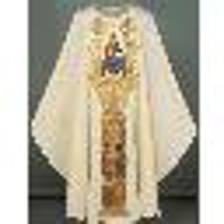

actual class 158


In [119]:
pred_index = 7777
display(test_ds[pred_index]["image"].resize((224, 224)))
print(f"actual class {test_ds[pred_index]['label']}")

In [120]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

pred_index_list = list([pred_index])

predict_dataloader = DataLoader(Subset(test_ds, pred_index_list), collate_fn=collate_fn, batch_size=1)

output = trainer.predict(model=model, dataloaders=predict_dataloader)
output = [i.item() for i in output]

print(f"Predicted classes: {output}")
print(f"Actual classes: {test_ds[pred_index_list]['label']}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Predicted classes: [158]
Actual classes: [158]
